In [1]:
library('Seurat')

Warning message:
“package ‘Seurat’ was built under R version 4.0.5”
Attaching SeuratObject



In [ ]:
# 细分
rds = readRDS('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20221110/Tcells.rds')
rds = NormalizeData(rds)
rds = ScaleData(rds)
rds <- FindVariableFeatures(object = rds)
genes.use<- head(HVFInfo(object = rds),2000)
rds <- RunPCA(object=rds,features = VariableFeatures(object = rds))
rds <- FindNeighbors(rds, reduction = "pca", dims = 1:20)
rds <- FindClusters(rds,resolution = 0.8, algorithm = 1)
rds <- RunTSNE(object=rds,dims.use=1:20,do.fast=TRUE,check_duplicates = FALSE)
rds <- RunUMAP(rds, reduction = "pca", dims = 1:20)
saveRDS(rds, '/SGRNJ06/randd/USER/cjj/celedev/XZMU/20221110/Tcells_scaled.rds')

In [2]:
# subset
rds = readRDS('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20221110/Tcells.rds')
Idents(rds) <- 'car'
rds <- subset(rds,idents = c('CAR+'))

In [4]:
saveRDS(rds, "/SGRNJ06/randd/USER/cjj/celedev/XZMU/20221110/Tcells_car_pos.rds")

In [ ]:
# marker gene
library('Seurat')
rds = readRDS('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20221110/Tcells_scaled.rds')
Idents(rds) <- "sample"
diff.wilcox = FindAllMarkers(rds)

In [4]:
write.csv(diff.wilcox,"/SGRNJ06/randd/USER/cjj/celedev/XZMU/20221110/allmarkers.csv")

In [1]:
library('Seurat')
library('ggplot2')
library("ggsci")
library('tidyverse')
library('monocle')
options(warn=-1)

Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

Warning message:
“package ‘tibble’ was built under R version 4.0.5”
Warning message:
“package ‘tidyr’ was built under R version 4.0.3”
Warning message:
“package ‘purrr’ was built under R version 4.0.3”
Warning message:
“package ‘stringr’ was built under R version 4.0.5”
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: Bi

In [3]:
#rds = readRDS('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20220923analysis/GC_1.2_T.rds')
#rds = readRDS('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20221110/Tcells.rds')
#rds = readRDS('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20221110/Tcells_scaled.rds')
#rds = readRDS('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20221110/Tcells_car_pos.rds')
#rds = readRDS('/SGRNJ06/randd/USER/cjj/celedev/yihe/S21.rds')
#rds  =readRDS("/SGRNJ06/randd/USER/cjj/celedev/XZMU/20230103/monocle/dyc_T.rds")
rds  =readRDS("/SGRNJ06/randd/USER/cjj/celedev/XZMU/20230103/monocle/wyp_T.rds")

In [4]:
table(rds@meta.data$sample)


DYC-0-X1 DYC-1-X1 DYC-2-X1 WYP-0-X2 WYP-1-X1 WYP-2-X2 
       0        0        0     3481     2907     3699 

In [5]:
data <- as.sparse(rds@assays$RNA@counts)
pd <- new('AnnotatedDataFrame', data = rds@meta.data)
fData <- data.frame(gene_short_name = row.names(data), row.names = row.names(data))
fd <- new('AnnotatedDataFrame', data = fData)
#Construct monocle cds
monocle_cds <- newCellDataSet(data,
                              phenoData = pd,
                              featureData = fd,
                              expressionFamily = negbinomial.size())
HSMM<-monocle_cds

In [6]:
HSMM <- estimateSizeFactors(HSMM)
HSMM <- estimateDispersions(HSMM)

Removing 121 outliers



In [6]:
diff.wilcox = read.csv('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20221110/allmarkers.csv')

In [8]:
##使用clusters差异表达基因
#Idents(rds) <- "sample"
#diff.wilcox = FindAllMarkers(rds)
all.markers = diff.wilcox %>% subset(p_val<0.05)
#diff.genes <- subset(all.markers,p_val_adj<0.01)$gene
diff.genes <- subset(all.markers,p_val_adj<0.05)$gene
HSMM <- setOrderingFilter(HSMM, diff.genes)
p1 <- plot_ordering_genes(HSMM)

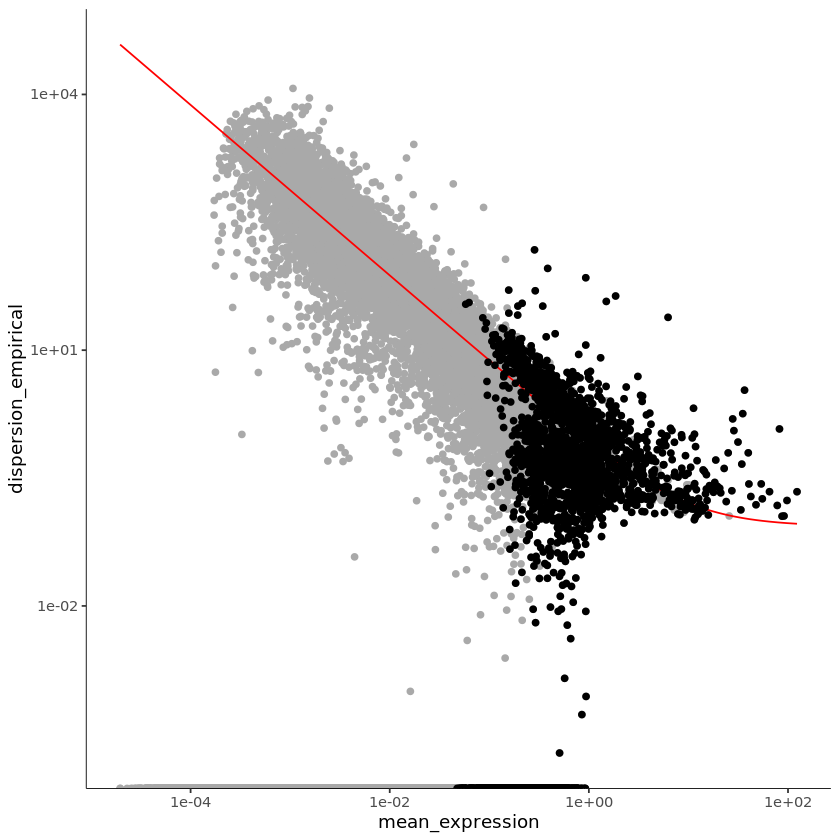

In [9]:
p1

In [ ]:
##使用seurat选择的高变基因
var.genes <- VariableFeatures(rds)
HSMM <- setOrderingFilter(HSMM, var.genes)
p2 <- plot_ordering_genes(HSMM)

In [7]:
##使用monocle选择的高变基因
disp_table <- dispersionTable(HSMM)
disp.genes <- subset(disp_table, mean_expression >= 0.1 & dispersion_empirical >= 1 * dispersion_fit)$gene_id
HSMM <- setOrderingFilter(HSMM, disp.genes)
p3 <- plot_ordering_genes(HSMM)

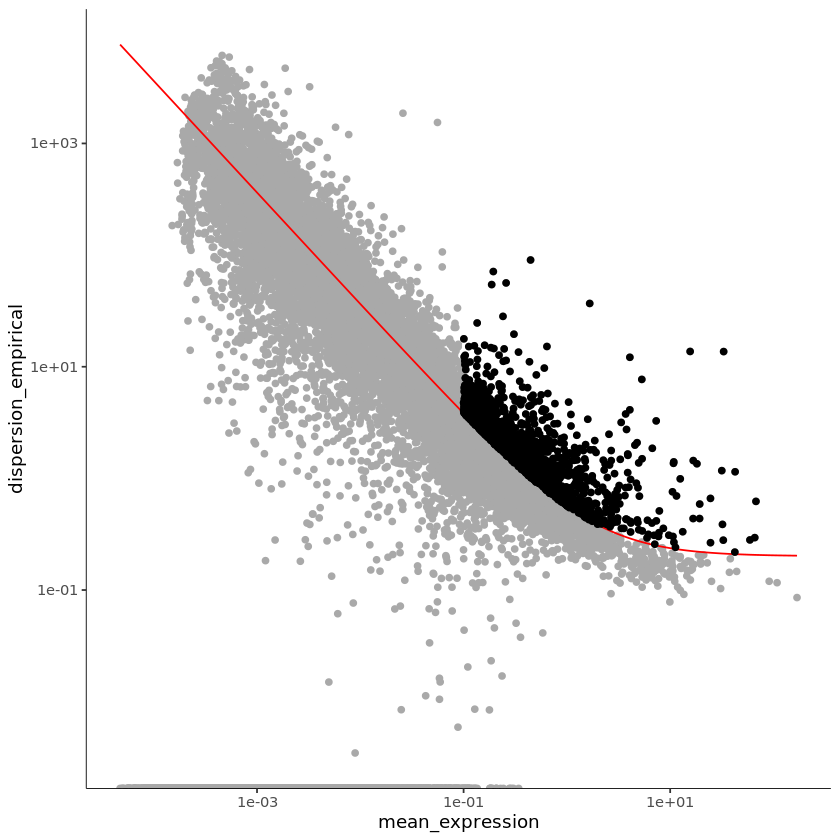

In [8]:
p3
#p1 | p2 | p3

In [9]:
HSMM <- reduceDimension(HSMM, max_components = 2, method = 'DDRTree')
HSMM <- orderCells(HSMM)

In [10]:
HSMM@phenoData@data

,orig.ident,nCount_RNA,nFeature_RNA,sample,sample_colors,group,group_colors,reportname,platform,percent.mt,cluster,cluster_colors,raw_cluster,raw_cluster_colors,louvain,seurat_cluster,car,Size_Factor,Pseudotime,State
,<fct>,<dbl>,<int>,<fct>,<chr>,<fct>,<chr>,<fct>,<chr>,<dbl>,<fct>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>
WYP-0-X2_AAACATCGAACAACCACGACTGGA,WYP-0-X2,12987,3238,WYP-0-X2,#FF1F1D,WYP-0-X2,#FF1F1D,WYP-0-X2,A,5.705706,CD4NaiveT,#0067AA,6,#B45B5D,6,6,CAR-,2.5444835,0.7512643,1
WYP-0-X2_AAACATCGAACGTGATCCGACAAC,WYP-0-X2,7833,2217,WYP-0-X2,#FF1F1D,WYP-0-X2,#FF1F1D,WYP-0-X2,A,5.132133,CD4NaiveT,#0067AA,6,#B45B5D,6,6,CAR+,1.5346839,0.7321959,1
WYP-0-X2_AAACATCGAAGGACACTTCACGCA,WYP-0-X2,20314,4008,WYP-0-X2,#FF1F1D,WYP-0-X2,#FF1F1D,WYP-0-X2,A,9.682978,CD4NaiveT,#0067AA,7,#FF8AB6,7,7,CAR+,3.9800291,0.2962645,1
WYP-0-X2_AAACATCGACACGACCAGTGGTCA,WYP-0-X2,3749,1460,WYP-0-X2,#FF1F1D,WYP-0-X2,#FF1F1D,WYP-0-X2,A,8.909042,CD4NaiveT,#0067AA,5,#A763AC,5,5,CAR+,0.7345244,5.2108923,1
WYP-0-X2_AAACATCGACCACTGTAACTCACC,WYP-0-X2,4499,1465,WYP-0-X2,#FF1F1D,WYP-0-X2,#FF1F1D,WYP-0-X2,A,9.379862,CD4NaiveT,#0067AA,5,#A763AC,5,5,CAR+,0.8814685,5.3656033,1
WYP-0-X2_AAACATCGACCACTGTAAGAGATC,WYP-0-X2,5290,1783,WYP-0-X2,#FF1F1D,WYP-0-X2,#FF1F1D,WYP-0-X2,A,6.257089,CD4NaiveT,#0067AA,5,#A763AC,5,5,CAR+,1.0364455,5.3481908,1
WYP-0-X2_AAACATCGACCACTGTGCCAAGAC,WYP-0-X2,5393,1709,WYP-0-X2,#FF1F1D,WYP-0-X2,#FF1F1D,WYP-0-X2,A,5.377341,CD8NaiveT,#00A23F,13,#727272,13,13,CAR-,1.0566258,1.7767232,1
WYP-0-X2_AAACATCGACGCTCGAGCTCGGTA,WYP-0-X2,7703,2237,WYP-0-X2,#FF1F1D,WYP-0-X2,#FF1F1D,WYP-0-X2,A,7.646371,CD8NaiveT,#00A23F,13,#727272,13,13,CAR-,1.5092136,0.5414611,1
WYP-0-X2_AAACATCGAGGCTAACCATACCAA,WYP-0-X2,13977,3205,WYP-0-X2,#FF1F1D,WYP-0-X2,#FF1F1D,WYP-0-X2,A,9.236603,CD4NaiveT,#0067AA,7,#FF8AB6,7,7,CAR+,2.7384497,0.4031061,1


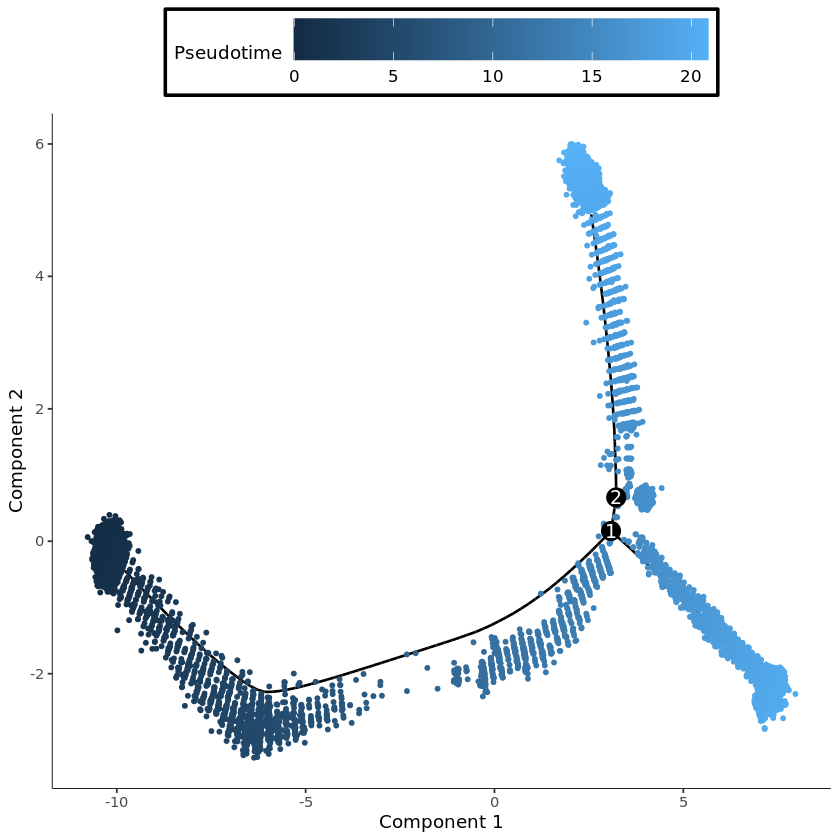

In [11]:
plot_cell_trajectory(HSMM, color_by = "Pseudotime",cell_size = 1) +
  theme(legend.text = element_text(size=10),legend.background = element_rect(colour='black', size=1),
        legend.key.size = unit(50, "pt"))

In [12]:
ggplot2::ggsave('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20230103/monocle/wyp/pseudotime.png', height=10, width=10)

In [13]:
# 有时候（大多数时候），拟时序的方向或是根节点弄错了，还需要手动更改
HSMM=orderCells(HSMM,root_state = 4) 

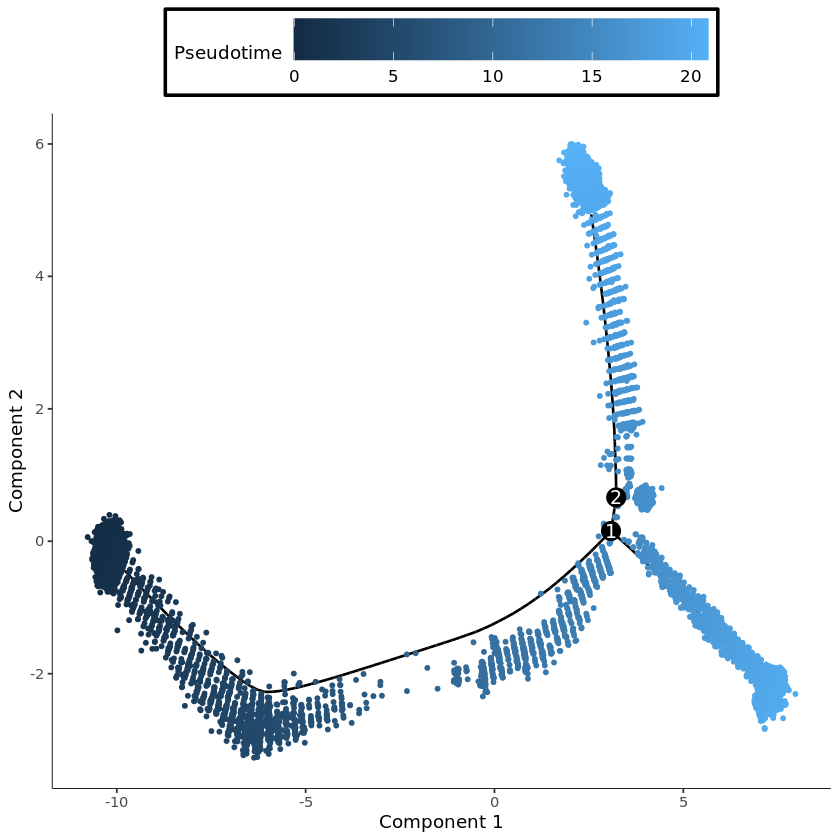

In [33]:
plot_cell_trajectory(HSMM, color_by = "Pseudotime",cell_size = 1) +
  theme(legend.text = element_text(size=10),legend.background = element_rect(colour='black', size=1),
        legend.key.size = unit(50, "pt"))

In [15]:
ggplot2::ggsave('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20221110/monocle/car_pos/repseudotime.png', height=10, width=10)

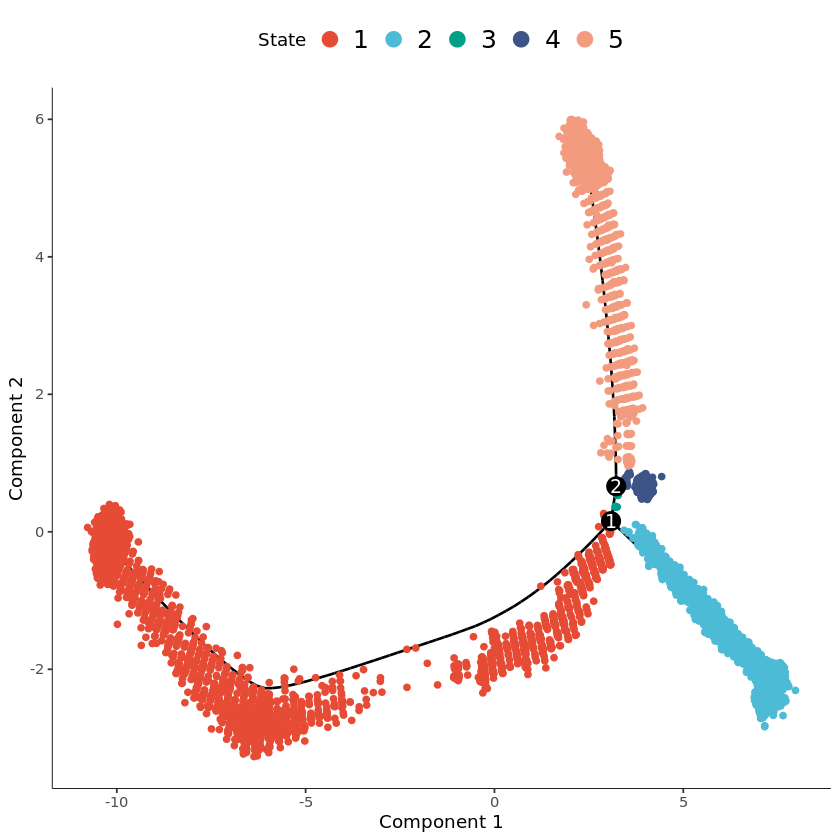

In [13]:
plot_cell_trajectory(HSMM, color_by = "State",cell_size = 1.5) + 
  guides(colour = guide_legend(override.aes = list(size=4)))+
  theme(legend.text = element_text(size=15))+ scale_color_npg()

In [14]:
ggplot2::ggsave('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20230103/monocle/wyp/state.png', height=10, width=10)

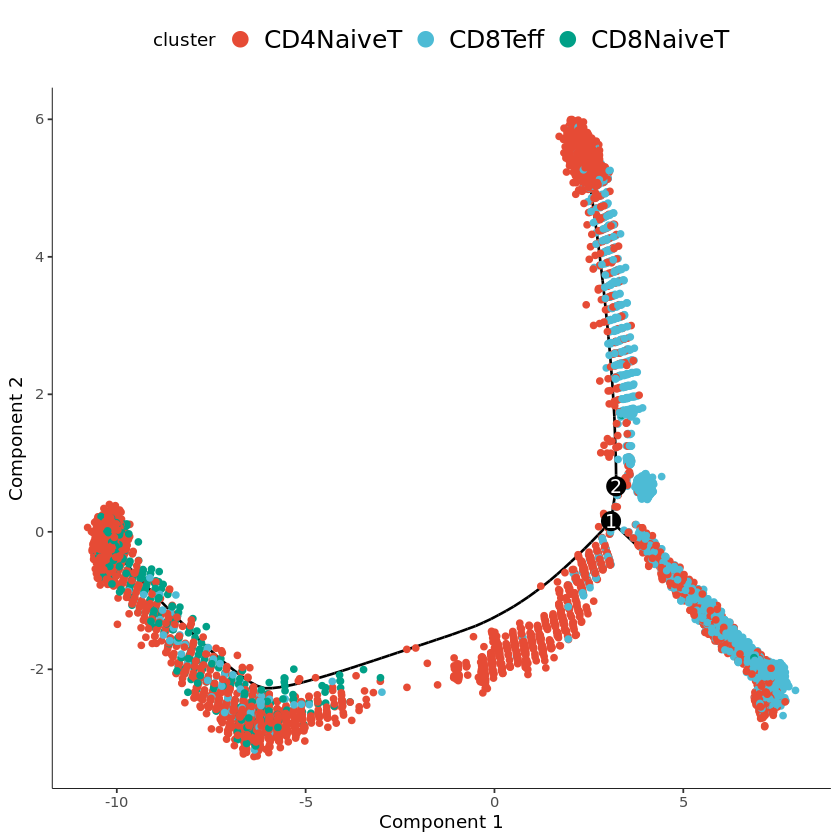

In [15]:
plot_cell_trajectory(HSMM, color_by = "cluster",cell_size = 1.5) + 
  guides(colour = guide_legend(override.aes = list(size=4)))+
  theme(legend.text = element_text(size=15))+ scale_color_npg()

In [16]:
ggplot2::ggsave('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20230103/monocle/wyp/celltype.png', height=10, width=10)

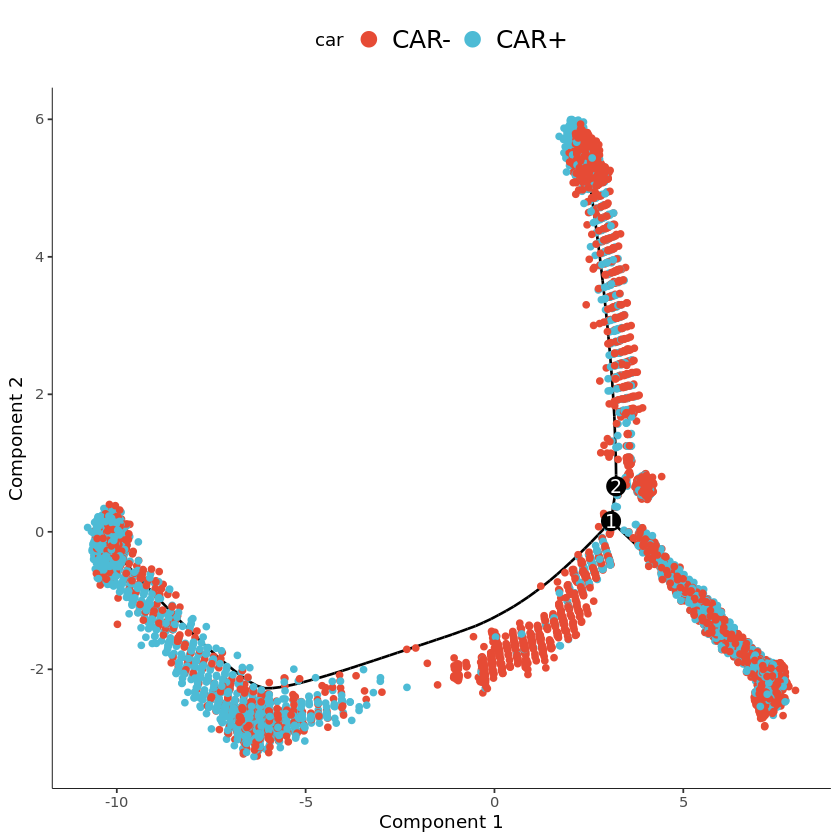

In [17]:
plot_cell_trajectory(HSMM, color_by = "car",cell_size = 1.5) + 
  guides(colour = guide_legend(override.aes = list(size=4)))+
  theme(legend.text = element_text(size=15))+ scale_color_npg()

In [18]:
ggplot2::ggsave('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20230103/monocle/wyp/car.png', height=10, width=10)

In [19]:
##分离CAR+和CAR-
meta = HSMM@phenoData@data
write.table(meta,file="/SGRNJ06/randd/USER/cjj/celedev/XZMU/20230103/monocle/wyp//HSMMmeta.xls",sep = '\t',quote=F,row.names=T)

In [20]:
#文件中有-时 需要xls另存为csv文件
meta=read.csv("/SGRNJ06/randd/USER/cjj/celedev/XZMU/20230103/monocle/wyp/HSMMmeta.csv",header = T, row.names = 1)
HSMM@phenoData@data=meta

In [43]:
meta=read.table("/SGRNJ06/randd/USER/cjj/celedev/XZMU/20230103/monocle/wyp/HSMMmeta.xls")
HSMM@phenoData@data=meta

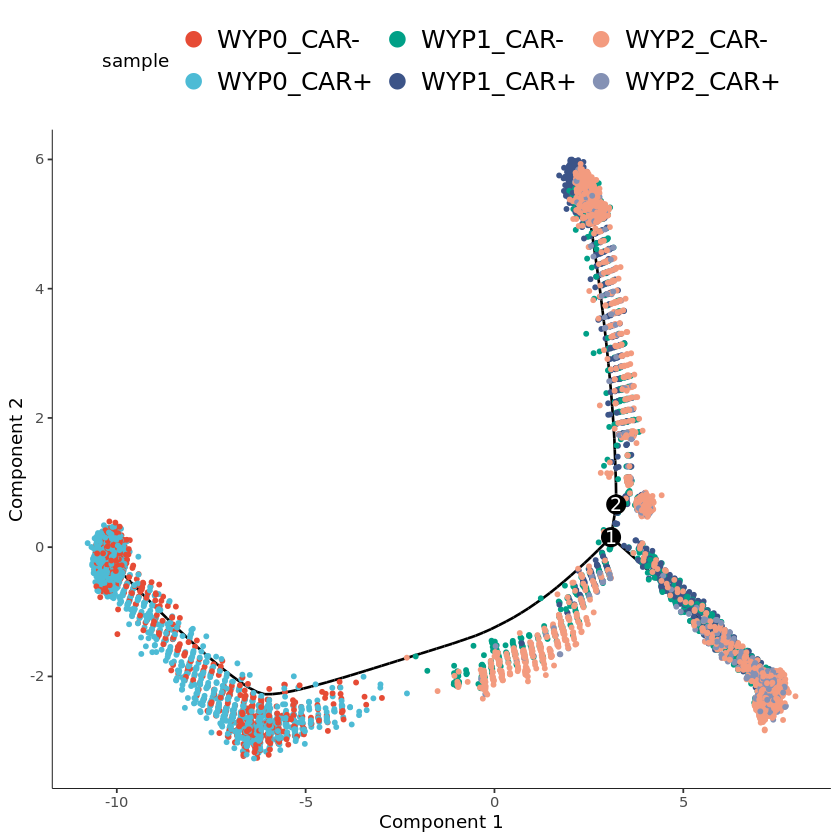

In [21]:
plot_cell_trajectory(HSMM, color_by = "sample",cell_size = 1) + 
  guides(colour = guide_legend(override.aes = list(size=4)))+
  theme(legend.text = element_text(size=15))+ scale_color_npg()

In [22]:
ggplot2::ggsave('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20230103/monocle/wyp/sample.png', height=10, width=10)

In [ ]:
meta=read.table("/SGRNJ06/randd/USER/cjj/celedev/XZMU/20220923analysis/monocle/HSMMmeta.xls")
HSMM@phenoData@data=meta

In [ ]:
show_col(pal_npg("nrc")(10))

In [73]:
target = c(pal_npg("nrc")(10)[8],pal_npg("nrc")(10)[2], pal_npg("nrc")(10)[3], pal_npg("nrc")(10)[4], pal_npg("nrc")(10)[5], pal_npg("nrc")(10)[6], pal_npg("nrc")(10)[7], pal_npg("nrc")(10)[9])

In [ ]:
show_col(target)

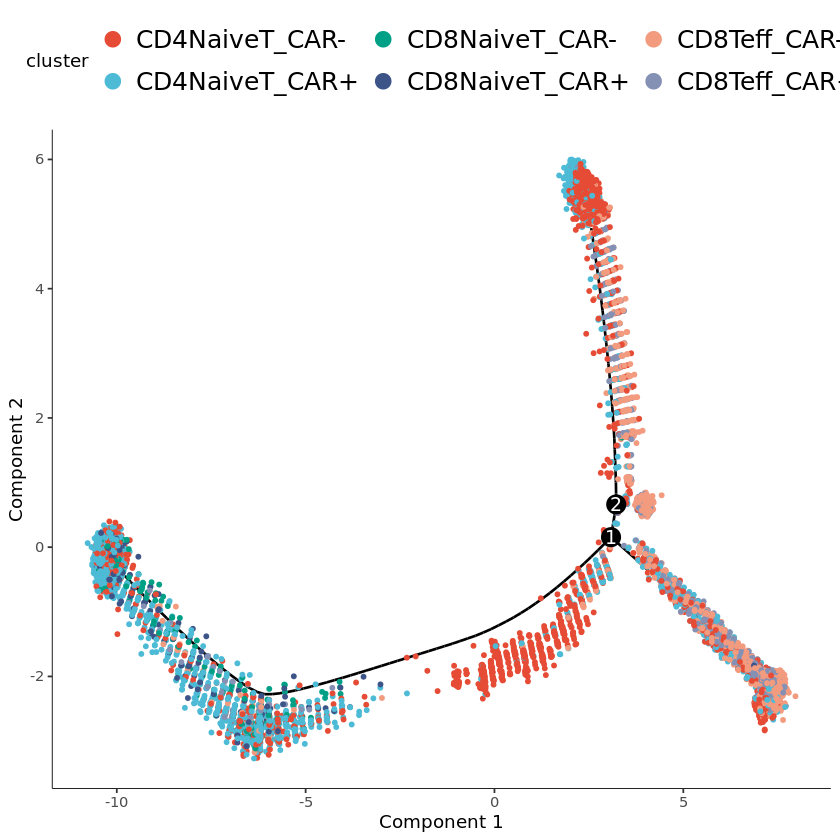

In [23]:
plot_cell_trajectory(HSMM, color_by = "cluster",cell_size = 1) + 
  guides(colour = guide_legend(override.aes = list(size=4))) +
  theme(legend.text = element_text(size=15)) + scale_color_npg()
#+ scale_color_npg(palette = target, alpha = 0.8)

In [24]:
ggplot2::ggsave('/SGRNJ06/randd/USER/cjj/celedev/XZMU/20230103/monocle/wyp/celltype_car.png', height=10, width=10)

In [22]:
meta = HSMM@phenoData@data

In [26]:
table(meta$State)


   1    2    3    4    5 
5117  461 2678 3988 3114 

In [ ]:
plot_cell_trajectory(HSMM, color_by = "State")

plot_cell_trajectory(HSMM, color_by = "Pseudotime",cell_size = 1) +
  theme(legend.text = element_text(size=10),legend.background = element_rect(colour='black', size=1),
        legend.key.size = unit(50, "pt"))

plot_cell_trajectory(HSMM, color_by = "celltype",cell_size = 1.5) + 
  guides(colour = guide_legend(override.aes = list(size=4)))+
  theme(legend.text = element_text(size=15))+ scale_color_npg()

In [ ]:
Idents(rds) <- "orig.ident"
rds0 = subset(rds,idents='GC_0_ZL')
rds1 = subset(rds,idents='GC_1_ZL')
rds2 = subset(rds,idents='GC_2_ZL')

In [ ]:
Idents(rds0) <- 'car'
Idents(rds1) <- 'car'
Idents(rds2) <- 'car'
m1 = FindMarkers(object = rds0,ident.1 = 'CAR+')
m2 = FindMarkers(object = rds1,ident.1 = 'CAR+')
m3 = FindMarkers(object = rds2,ident.1 = 'CAR+')

In [ ]:
write.table(m1,'/SGRNJ06/randd/USER/cjj/celedev/XZMU/20220923analysis/marker/gc0.tsv',sep='\t',quote=F,row.names=T)
write.table(m2,'/SGRNJ06/randd/USER/cjj/celedev/XZMU/20220923analysis/marker/gc1.tsv',sep='\t',quote=F,row.names=T)
write.table(m3,'/SGRNJ06/randd/USER/cjj/celedev/XZMU/20220923analysis/marker/gc2.tsv',sep='\t',quote=F,row.names=T)

In [ ]:
m3

In [ ]:
library('monocle')

In [ ]:
sessionInfo()

In [ ]:
rds@meta.data

In [ ]:
Idents(rds) <- "orig.ident"
markers = FindAllMarkers(rds)

In [10]:

1+1

[1] 2

In [14]:
meta = HSMM@phenoData@data
write.table(meta,file="/SGRNJ06/randd/USER/cjj/celedev/XZMU/20221110/monocle/check.tsv",sep = '\t',quote=F,row.names=T)